# Tree model, depth 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas
import numpy
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.metrics import log_loss

In [4]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [5]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB

In [6]:
import itertools

In [7]:
data = loan_approval_lib.load_original_data()

In [8]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


In [10]:
loan_grade_unique = list(sorted(data['loan_grade'].unique()))
loan_grade_unique

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [12]:
data_loan_grade = {
    loan_grade: data[data['loan_grade'] == loan_grade] for loan_grade in loan_grade_unique
}
list(data_loan_grade.keys())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Create model based on `person_home_ownership`

In [16]:
for key, data_loan_grade_ in data_loan_grade.items():

    model_column = 'person_home_ownership'
    
    data_categorical = data_loan_grade_.copy()
    data_categorical = data_categorical[[model_column, 'loan_status']]

    data_categorical = data_categorical.groupby(by=[model_column]).aggregate(
        {
            'loan_status': [('loan_status_sum', 'sum'), ('loan_status_count', 'count')],
        }
    )
    data_categorical.columns = [column[1] for column in data_categorical.columns]
    data_categorical = data_categorical.reset_index()
    
    data_categorical['loan_status_proba'] = data_categorical['loan_status_sum'] / data_categorical['loan_status_count']
    data_categorical['loan_status_model'] = round(data_categorical['loan_status_proba'])

    model = data_categorical

    data_loan_grade_with_model = data_loan_grade_.copy()
    data_loan_grade_with_model[f'loan_status_model'] = data_loan_grade_with_model[model_column].map(
        model.set_index(model_column)['loan_status_model'].to_dict()
    )

    accuracy = (data_loan_grade_with_model['loan_status'] == data_loan_grade_with_model['loan_status_model']).sum() / len(data_loan_grade_with_model)
    accuracy_all_0 = (data_loan_grade_with_model['loan_status'] == 0).sum() / len(data_loan_grade_with_model)
    accuracy_all_1 = (data_loan_grade_with_model['loan_status'] == 1).sum() / len(data_loan_grade_with_model)

    accuracy = round(accuracy, 3)
    accuracy_all_0 = round(accuracy_all_0, 3)
    accuracy_all_1 = round(accuracy_all_1, 3)
    
    print(f'model {model_column}: grade={key}, accuracy={accuracy}, accuracy_all_0={accuracy_all_0}, accuracy_all_1={accuracy_all_1}')

    
    

model person_home_ownership: grade=A, accuracy=0.9, accuracy_all_0=0.9, accuracy_all_1=0.1
model person_home_ownership: grade=B, accuracy=0.837, accuracy_all_0=0.837, accuracy_all_1=0.163
model person_home_ownership: grade=C, accuracy=0.793, accuracy_all_0=0.793, accuracy_all_1=0.207
model person_home_ownership: grade=D, accuracy=0.687, accuracy_all_0=0.41, accuracy_all_1=0.59
model person_home_ownership: grade=E, accuracy=0.662, accuracy_all_0=0.356, accuracy_all_1=0.644
model person_home_ownership: grade=F, accuracy=0.705, accuracy_all_0=0.295, accuracy_all_1=0.705
model person_home_ownership: grade=G, accuracy=0.984, accuracy_all_0=0.016, accuracy_all_1=0.984


## Summary

- Adding model based on `person_home_ownership` improves `loan_grade` `D` only
- Find out why, plot distribution

In [17]:
data_loan_grade_D = data_loan_grade['D']
data_loan_grade_D

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,0.16,N,3,1
18,23,113000,RENT,8.0,DEBTCONSOLIDATION,D,35000,18.25,0.31,N,4,1
22,22,65000,RENT,4.0,EDUCATION,D,34000,17.58,0.52,N,4,1
24,22,80000,RENT,3.0,PERSONAL,D,33950,14.54,0.42,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32517,55,28800,OWN,1.0,PERSONAL,D,5000,15.33,0.17,N,22,0
32527,69,120000,MORTGAGE,3.0,PERSONAL,D,20000,14.84,0.17,N,27,0
32541,52,163000,MORTGAGE,9.0,PERSONAL,D,25000,14.11,0.15,N,30,1
32554,60,98000,RENT,1.0,HOMEIMPROVEMENT,D,15000,16.29,0.15,N,29,1


In [18]:
person_home_ownership_unique = list(sorted(data_loan_grade_D['person_home_ownership'].unique()))
person_home_ownership_unique

['MORTGAGE', 'OTHER', 'OWN', 'RENT']

In [21]:
data_loan_grade_D_person_home_ownership = {
    person_home_ownership: data_loan_grade_D[data_loan_grade_D['person_home_ownership'] == person_home_ownership]
        for person_home_ownership in person_home_ownership_unique
}
list(data_loan_grade_D_person_home_ownership.keys())

['MORTGAGE', 'OTHER', 'OWN', 'RENT']

# Plot Loan Grade D

In [23]:
# Want in dataframe format instead of dictionary format

data_loan_grade_D_by_person_home_ownership = data_loan_grade_D.groupby(
    by=['person_home_ownership', 'loan_status']
)['loan_int_rate'].count() # dummy column
data_loan_grade_D_by_person_home_ownership = data_loan_grade_D_by_person_home_ownership.unstack()
data_loan_grade_D_by_person_home_ownership

loan_status,0,1
person_home_ownership,,
MORTGAGE,597,507
OTHER,9,7
OWN,243,17
RENT,494,1440


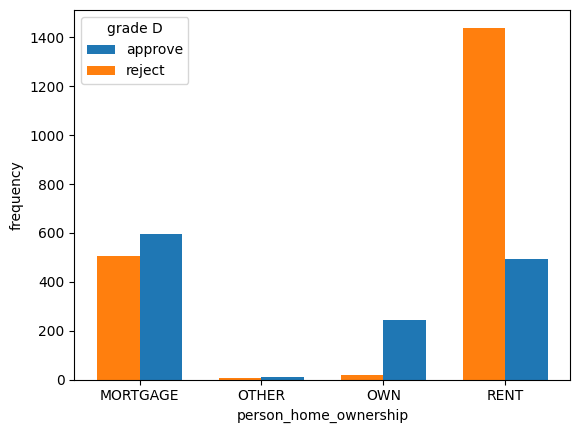

In [24]:
person_home_ownership_values = data_loan_grade_D_by_person_home_ownership.index.tolist()
x = numpy.arange(len(person_home_ownership_values))
width = 0.35

plt.bar(x + width/2, data_loan_grade_D_by_person_home_ownership[0], width, label='approve')
plt.bar(x - width/2, data_loan_grade_D_by_person_home_ownership[1], width, label='reject')

plt.xlabel('person_home_ownership')
plt.ylabel('frequency')
plt.xticks(x, person_home_ownership_values)
plt.legend(title='grade D')

plt.savefig(f'loan_grade_D-person_home_ownership.pdf')
None

# Plot All Loan Grades (except D)

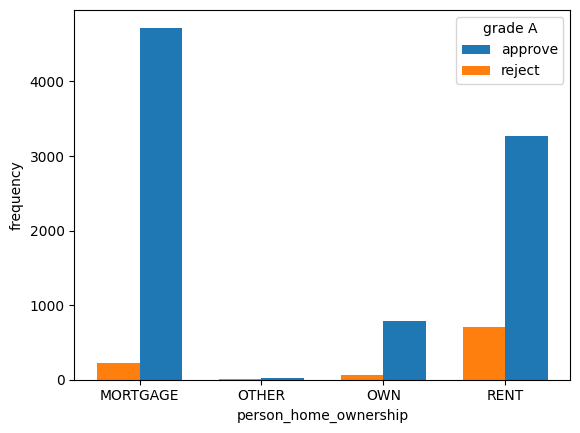

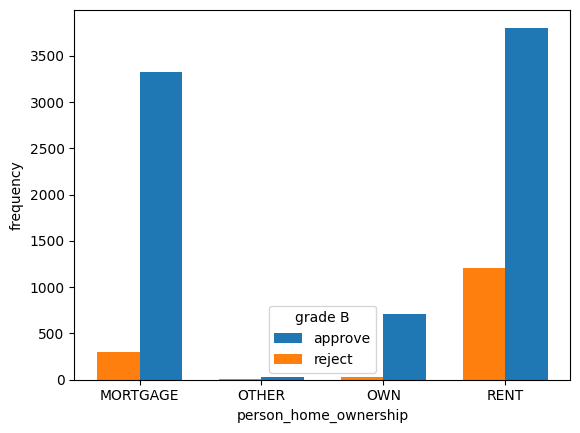

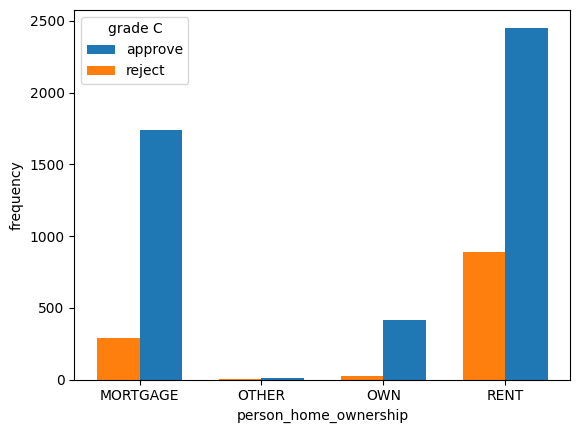

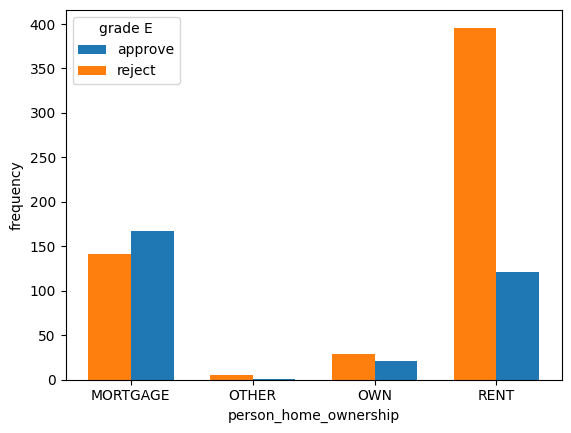

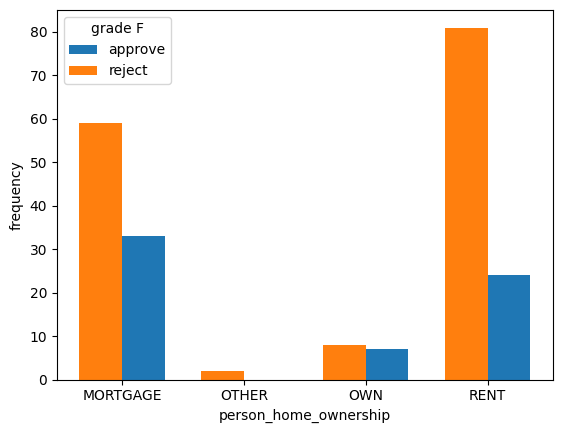

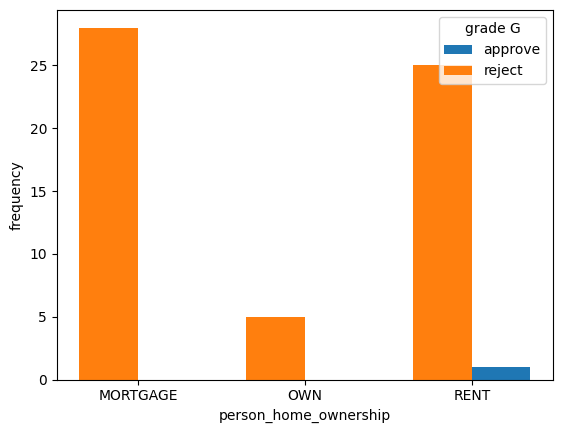

In [29]:
for loan_grade, data_loan_grade_X in data_loan_grade.items():

    if loan_grade == 'D':
        continue
    
    data_loan_grade_X_by_person_home_ownership = data_loan_grade_X.groupby(
        by=['person_home_ownership', 'loan_status']
    )['loan_int_rate'].count() # dummy column
    data_loan_grade_X_by_person_home_ownership = data_loan_grade_X_by_person_home_ownership.unstack()

    person_home_ownership_values = data_loan_grade_X_by_person_home_ownership.index.tolist()
    x = numpy.arange(len(person_home_ownership_values))
    width = 0.35

    plt.figure()
    plt.bar(x + width/2, data_loan_grade_X_by_person_home_ownership[0], width, label='approve')
    plt.bar(x - width/2, data_loan_grade_X_by_person_home_ownership[1], width, label='reject')
    
    plt.xlabel('person_home_ownership')
    plt.ylabel('frequency')
    plt.xticks(x, person_home_ownership_values)
    plt.legend(title=f'grade {loan_grade}')
    
    plt.savefig(f'loan_grade_{loan_grade}-person_home_ownership.pdf')
    None

# Plot all Loan Grades as Probabilities

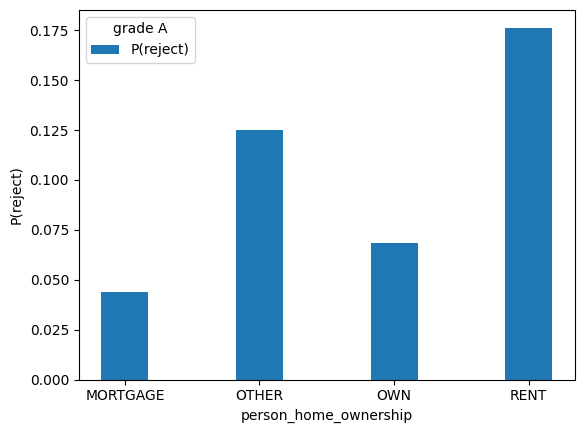

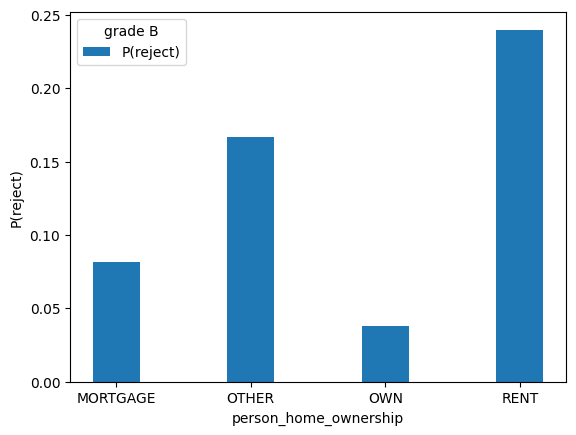

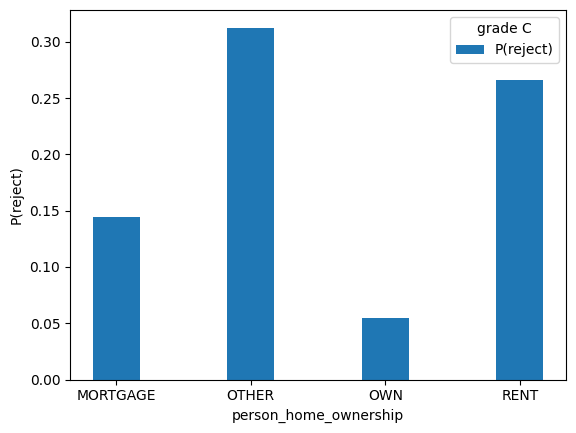

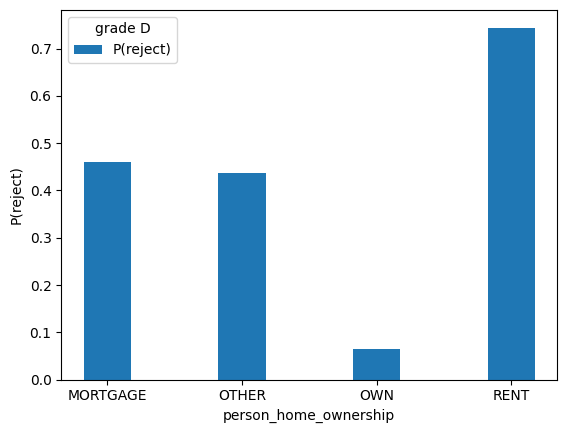

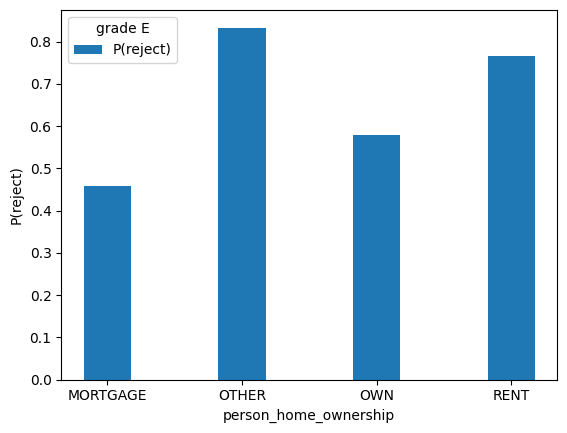

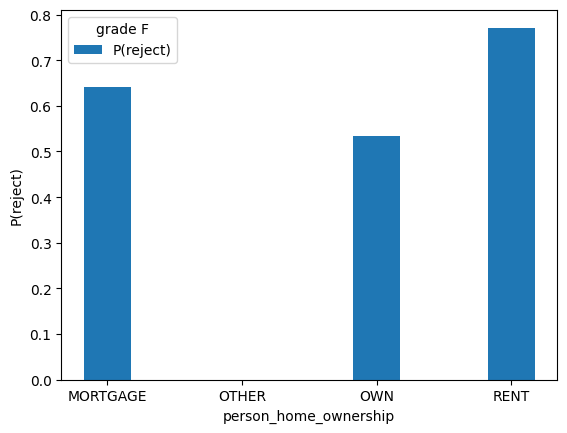

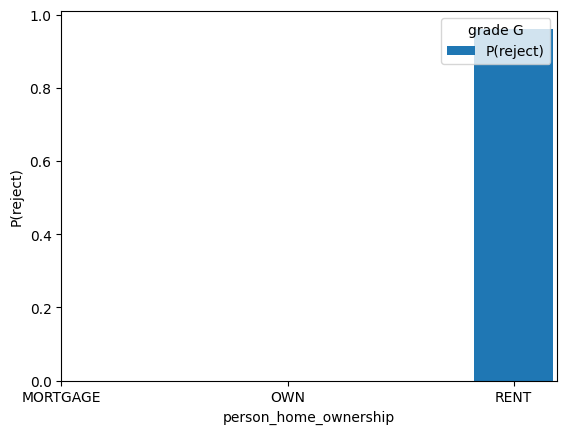

In [31]:
for loan_grade, data_loan_grade_X in data_loan_grade.items():

    data_loan_grade_X_by_person_home_ownership = data_loan_grade_X.groupby(
        by=['person_home_ownership', 'loan_status']
    )['loan_int_rate'].count() # dummy column
    data_loan_grade_X_by_person_home_ownership = data_loan_grade_X_by_person_home_ownership.unstack()

    person_home_ownership_values = data_loan_grade_X_by_person_home_ownership.index.tolist()
    x = numpy.arange(len(person_home_ownership_values))
    width = 0.35

    plt.figure()

    data_tmp = data_loan_grade_X_by_person_home_ownership[1] / (
        data_loan_grade_X_by_person_home_ownership[0] + data_loan_grade_X_by_person_home_ownership[1]
    )
    
    plt.bar(x, data_tmp, width, label='P(reject)')
    
    plt.xlabel('person_home_ownership')
    plt.ylabel('P(reject)')
    plt.xticks(x, person_home_ownership_values)
    plt.legend(title=f'grade {loan_grade}')
    
    plt.savefig(f'loan_grade_{loan_grade}-person_home_ownership-reject_prob.pdf')
    None

# Plot the other combination

- Plot `person_home_ownership` on different figure
- Compare `P(reject)` by `loan_grade`

In [34]:
data_person_home_ownership_unique = list(sorted(data['person_home_ownership'].unique()))

In [35]:
data_person_home_ownership = {
    person_home_ownership: data[data['person_home_ownership'] == person_home_ownership]
        for person_home_ownership in person_home_ownership_unique
}

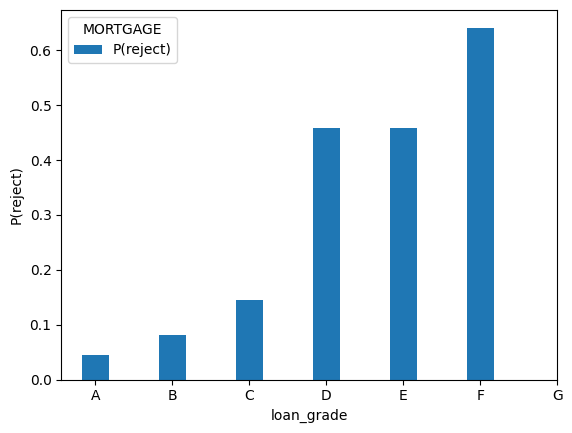

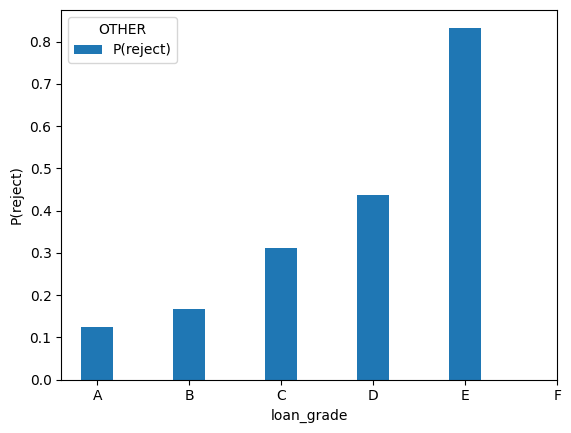

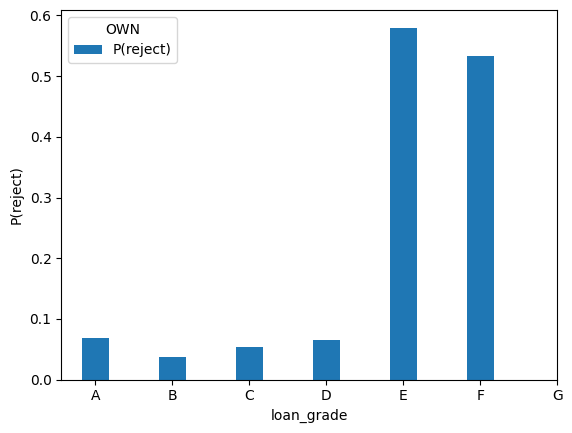

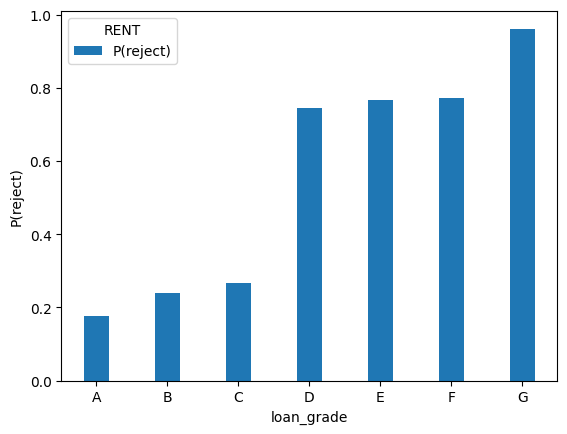

In [37]:
for person_home_ownership, data_person_home_ownership_X in data_person_home_ownership.items():

    data_person_home_ownership_X_by_loan_grade = data_person_home_ownership_X.groupby(
        by=['loan_grade', 'loan_status']
    )['loan_int_rate'].count() # dummy column
    data_person_home_ownership_X_by_loan_grade = data_person_home_ownership_X_by_loan_grade.unstack()

    loan_grade_values = data_person_home_ownership_X_by_loan_grade.index.tolist()
    x = numpy.arange(len(loan_grade_values))
    width = 0.35

    plt.figure()

    data_tmp = data_person_home_ownership_X_by_loan_grade[1] / (
        data_person_home_ownership_X_by_loan_grade[0] + data_person_home_ownership_X_by_loan_grade[1]
    )
    
    plt.bar(x, data_tmp, width, label='P(reject)')
    
    plt.xlabel('loan_grade')
    plt.ylabel('P(reject)')
    plt.xticks(x, loan_grade_values)
    plt.legend(title=f'{person_home_ownership}')
    
    plt.savefig(f'person_home_ownership_{person_home_ownership}-loan_grade-reject_prob.pdf')
    None

# Plot single figure

In [55]:
data_by_loan_grade_person_home_ownership_and_status = data.groupby(
    by=['loan_grade', 'person_home_ownership', 'loan_status']
)['loan_int_rate'].count()
data_by_loan_grade_person_home_ownership_and_status = data_by_loan_grade_person_home_ownership_and_status.unstack()
data_by_loan_grade_person_home_ownership_and_status

loan_status                            0       1
loan_grade person_home_ownership                
A          MORTGAGE               4723.0   217.0
           OTHER                    21.0     3.0
           OWN                     787.0    58.0
           RENT                   3266.0   699.0
B          MORTGAGE               3326.0   294.0
           OTHER                    25.0     5.0
           OWN                     711.0    28.0
           RENT                   3805.0  1201.0
C          MORTGAGE               1737.0   293.0
           OTHER                    11.0     5.0
           OWN                     418.0    24.0
           RENT                   2453.0   887.0
D          MORTGAGE                597.0   507.0
           OTHER                     9.0     7.0
           OWN                     243.0    17.0
           RENT                    494.0  1440.0
E          MORTGAGE                167.0   141.0
           OTHER                     1.0     5.0
           OWN                      21.0    29.0
           RENT                    121.0   396.0
F          MORTGAGE                 33.0    59.0
           OTHER                     NaN     2.0
           OWN                       7.0     8.0
           RENT                     24.0    81.0
G          MORTGAGE                  NaN    28.0
           OWN                       NaN     5.0
           RENT                      1.0    25.0

In [56]:
data_by_loan_grade_person_home_ownership_and_status = data_by_loan_grade_person_home_ownership_and_status.fillna(0)
data_by_loan_grade_person_home_ownership_and_status

loan_status                            0       1
loan_grade person_home_ownership                
A          MORTGAGE               4723.0   217.0
           OTHER                    21.0     3.0
           OWN                     787.0    58.0
           RENT                   3266.0   699.0
B          MORTGAGE               3326.0   294.0
           OTHER                    25.0     5.0
           OWN                     711.0    28.0
           RENT                   3805.0  1201.0
C          MORTGAGE               1737.0   293.0
           OTHER                    11.0     5.0
           OWN                     418.0    24.0
           RENT                   2453.0   887.0
D          MORTGAGE                597.0   507.0
           OTHER                     9.0     7.0
           OWN                     243.0    17.0
           RENT                    494.0  1440.0
E          MORTGAGE                167.0   141.0
           OTHER                     1.0     5.0
           OWN                      21.0    29.0
           RENT                    121.0   396.0
F          MORTGAGE                 33.0    59.0
           OTHER                     0.0     2.0
           OWN                       7.0     8.0
           RENT                     24.0    81.0
G          MORTGAGE                  0.0    28.0
           OWN                       0.0     5.0
           RENT                      1.0    25.0

In [66]:
data_by_loan_grade_person_home_ownership_and_status['P_reject'] = (
    data_by_loan_grade_person_home_ownership_and_status[1] / 
        (data_by_loan_grade_person_home_ownership_and_status[1] + data_by_loan_grade_person_home_ownership_and_status[0])
)
data_by_loan_grade_person_home_ownership_and_status

loan_status                            0       1  P_reject
loan_grade person_home_ownership                          
A          MORTGAGE               4723.0   217.0  0.043927
           OTHER                    21.0     3.0  0.125000
           OWN                     787.0    58.0  0.068639
           RENT                   3266.0   699.0  0.176293
B          MORTGAGE               3326.0   294.0  0.081215
           OTHER                    25.0     5.0  0.166667
           OWN                     711.0    28.0  0.037889
           RENT                   3805.0  1201.0  0.239912
C          MORTGAGE               1737.0   293.0  0.144335
           OTHER                    11.0     5.0  0.312500
           OWN                     418.0    24.0  0.054299
           RENT                   2453.0   887.0  0.265569
D          MORTGAGE                597.0   507.0  0.459239
           OTHER                     9.0     7.0  0.437500
           OWN                     243.0    17.0  0.065385
           RENT                    494.0  1440.0  0.744571
E          MORTGAGE                167.0   141.0  0.457792
           OTHER                     1.0     5.0  0.833333
           OWN                      21.0    29.0  0.580000
           RENT                    121.0   396.0  0.765957
F          MORTGAGE                 33.0    59.0  0.641304
           OTHER                     0.0     2.0  1.000000
           OWN                       7.0     8.0  0.533333
           RENT                     24.0    81.0  0.771429
G          MORTGAGE                  0.0    28.0  1.000000
           OWN                       0.0     5.0  1.000000
           RENT                      1.0    25.0  0.961538

In [67]:
grades = data_by_loan_grade_person_home_ownership_and_status.index.tolist()
grades = list(sorted(set(map(lambda x: x[0], grades))))
grades

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [68]:
data_by_loan_grade_person_home_ownership_and_status['P_reject'].unstack()

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_grade,,,,
A,0.043927,0.125000,0.068639,0.176293
B,0.081215,0.166667,0.037889,0.239912
C,0.144335,0.312500,0.054299,0.265569
D,0.459239,0.437500,0.065385,0.744571
E,0.457792,0.833333,0.580000,0.765957
F,0.641304,1.000000,0.533333,0.771429
G,1.000000,NaN,1.000000,0.961538


In [69]:
data_tmp = data_by_loan_grade_person_home_ownership_and_status['P_reject'].unstack()

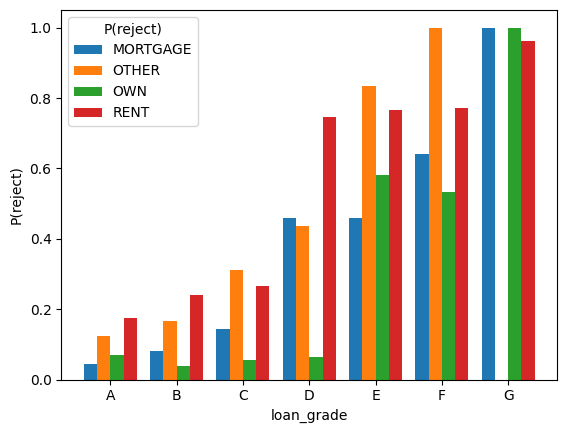

In [79]:
x = numpy.arange(len(grades))
width = 0.2

labels = data_tmp.index.tolist()

for i, person_home_ownership in enumerate(data_tmp.columns.tolist()):
    plt.bar(x + i*width, data_tmp[person_home_ownership], width, label=f'{person_home_ownership}')

plt.xticks(x + width*(len(data_tmp.columns)-1)/2, labels)
plt.legend(title='P(reject)')
plt.ylabel('P(reject)')
plt.xlabel('loan_grade')

plt.savefig('loan_grade-person_home_ownership.pdf')
None